<a href="https://colab.research.google.com/github/jenboland/DailyKnowledge/blob/master/pymc_mmm_time_varying_media_2025.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/pymc-labs/pymc-marketing.git

  Cloning https://github.com/pymc-labs/pymc-marketing.git to /tmp/pip-req-build-ya0vtrz7
  Running command git clone --filter=blob:none --quiet https://github.com/pymc-labs/pymc-marketing.git /tmp/pip-req-build-ya0vtrz7
  Resolved https://github.com/pymc-labs/pymc-marketing.git to commit eec024de397e6713e9d49c12300eb1cc91fcef7b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pymc-marketing: filename=pymc_marketing-0.11.1-py3-none-any.whl size=243921 sha256=b3f0f35b101561058e1e4f4a1ff0ea89189126ac93198ffd1abe543e8cf723e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-e0yjqer4/wheels/74/4e/df/061764542e2335eb91488d930c91f3e06058325d53a008deb7
Successfully built pymc-marketing


In [ ]:
!pip install numpyro


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 360.8/360.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns
import numpyro

from pymc_marketing.mmm import MMM, GeometricAdstock, LogisticSaturation, MichaelisMentenSaturation
from pymc_marketing.mmm.transformers import geometric_adstock, logistic_saturation

warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"


In [ ]:
import pymc_marketing
print(pymc_marketing.__version__)

0.11.1


In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path_ = "/content/drive/MyDrive/Colab Notebooks/"

In [ ]:
bing = pd.read_csv(path_+'cafb_bing_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
dm = pd.read_csv(path_+'cafb_direct_mail_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
email = pd.read_csv(path_+'cafb_email_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
fb = pd.read_csv(path_+'cafb_facebook_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
paid_search = pd.read_csv(path_+'cafb_google_paid_search.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
prog = pd.read_csv(path_+'cafb_programmatic_daily.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
sales = pd.read_csv(path_+'cafb_transactions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()
#remove v2 from excel file name
ftf = pd.read_excel(path_+'CAFB MMM Telefundraising Data 2022-2024v2.xlsx', sheet_name = 'transposed', parse_dates=['timestamp']).fillna(0).rename(columns={'timestamp':'Date'}).set_index('Date').resample('W').sum()
ga4 = pd.read_csv(path_+'cafb_ga4_sessions.csv', parse_dates=['Date'], index_col=['Date']).resample('W').sum()

fb = fb.rename(columns={'Impressions':'FB_Impressions', 'Spend':'FB_Spend'})
ftf = ftf.rename(columns={'calls':'FTF_Impressions', 'funds':'FTF_Spend'})


In [ ]:
df = pd.concat([bing, dm, email, fb, paid_search, prog, ftf ,sales], axis=1).fillna(0).head(144).reset_index()
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

df.head(2)

,Date,Bing_Branded_Impressions,Bing_Branded_Spend,Bing_NonBranded_Impressions,Bing_NonBranded_Spend,DM_Spend,DM_Impressions,Email_Impressions,Email_Spend,FB_Spend,...,GoogleAds_Branded_Impressions,GoogleAds_Branded_Spend,GoogleAds_NonBranded_Impressions,GoogleAds_NonBranded_Spend,Programatic_Spend,Programatic_Impressions,FTF_Spend,FTF_Impressions,contacts,Revenue
0,2022-01-02,1.0,3.26,3852.0,210.97,0.0,0.0,0.0,0.0,0.0,...,147.0,86.76,1365.0,196.73,0.0,0.0,0.0,0.0,0.0,44191.7
1,2022-01-09,64.0,8.25,4482.0,757.49,0.0,0.0,0.0,0.0,0.0,...,806.0,496.89,7085.0,1300.33,0.0,0.0,3036.0,6487.0,561.0,99989.5


In [ ]:
df['GoogleAds_Impressions'] = df['GoogleAds_Branded_Impressions'] + df['GoogleAds_NonBranded_Impressions']
df['GoogleAds_Spend'] = df['GoogleAds_Branded_Spend'] + df['GoogleAds_NonBranded_Spend']

df['Bing_Impressions'] = df['Bing_Branded_Impressions'] + df['Bing_NonBranded_Impressions']
df['Bing_Spend'] = df['Bing_Branded_Spend'] + df['Bing_NonBranded_Spend']

In [ ]:
df["eoy_campaign"] = df["Date"].apply(lambda x: 1 if x.month in [11, 12] else 0)
df["end_of_year"] = ((df["Date"].dt.month == 12) & (df["Date"].dt.day == 31)) | ((df["Date"].dt.month == 1) & (df["Date"].dt.day == 1))
df['trend'] = df['Revenue'].shift(1).fillna(method="bfill")

In [ ]:
df['end_of_year'].sum()

2

<ipython-input-12-1a5ac69e9fc7>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


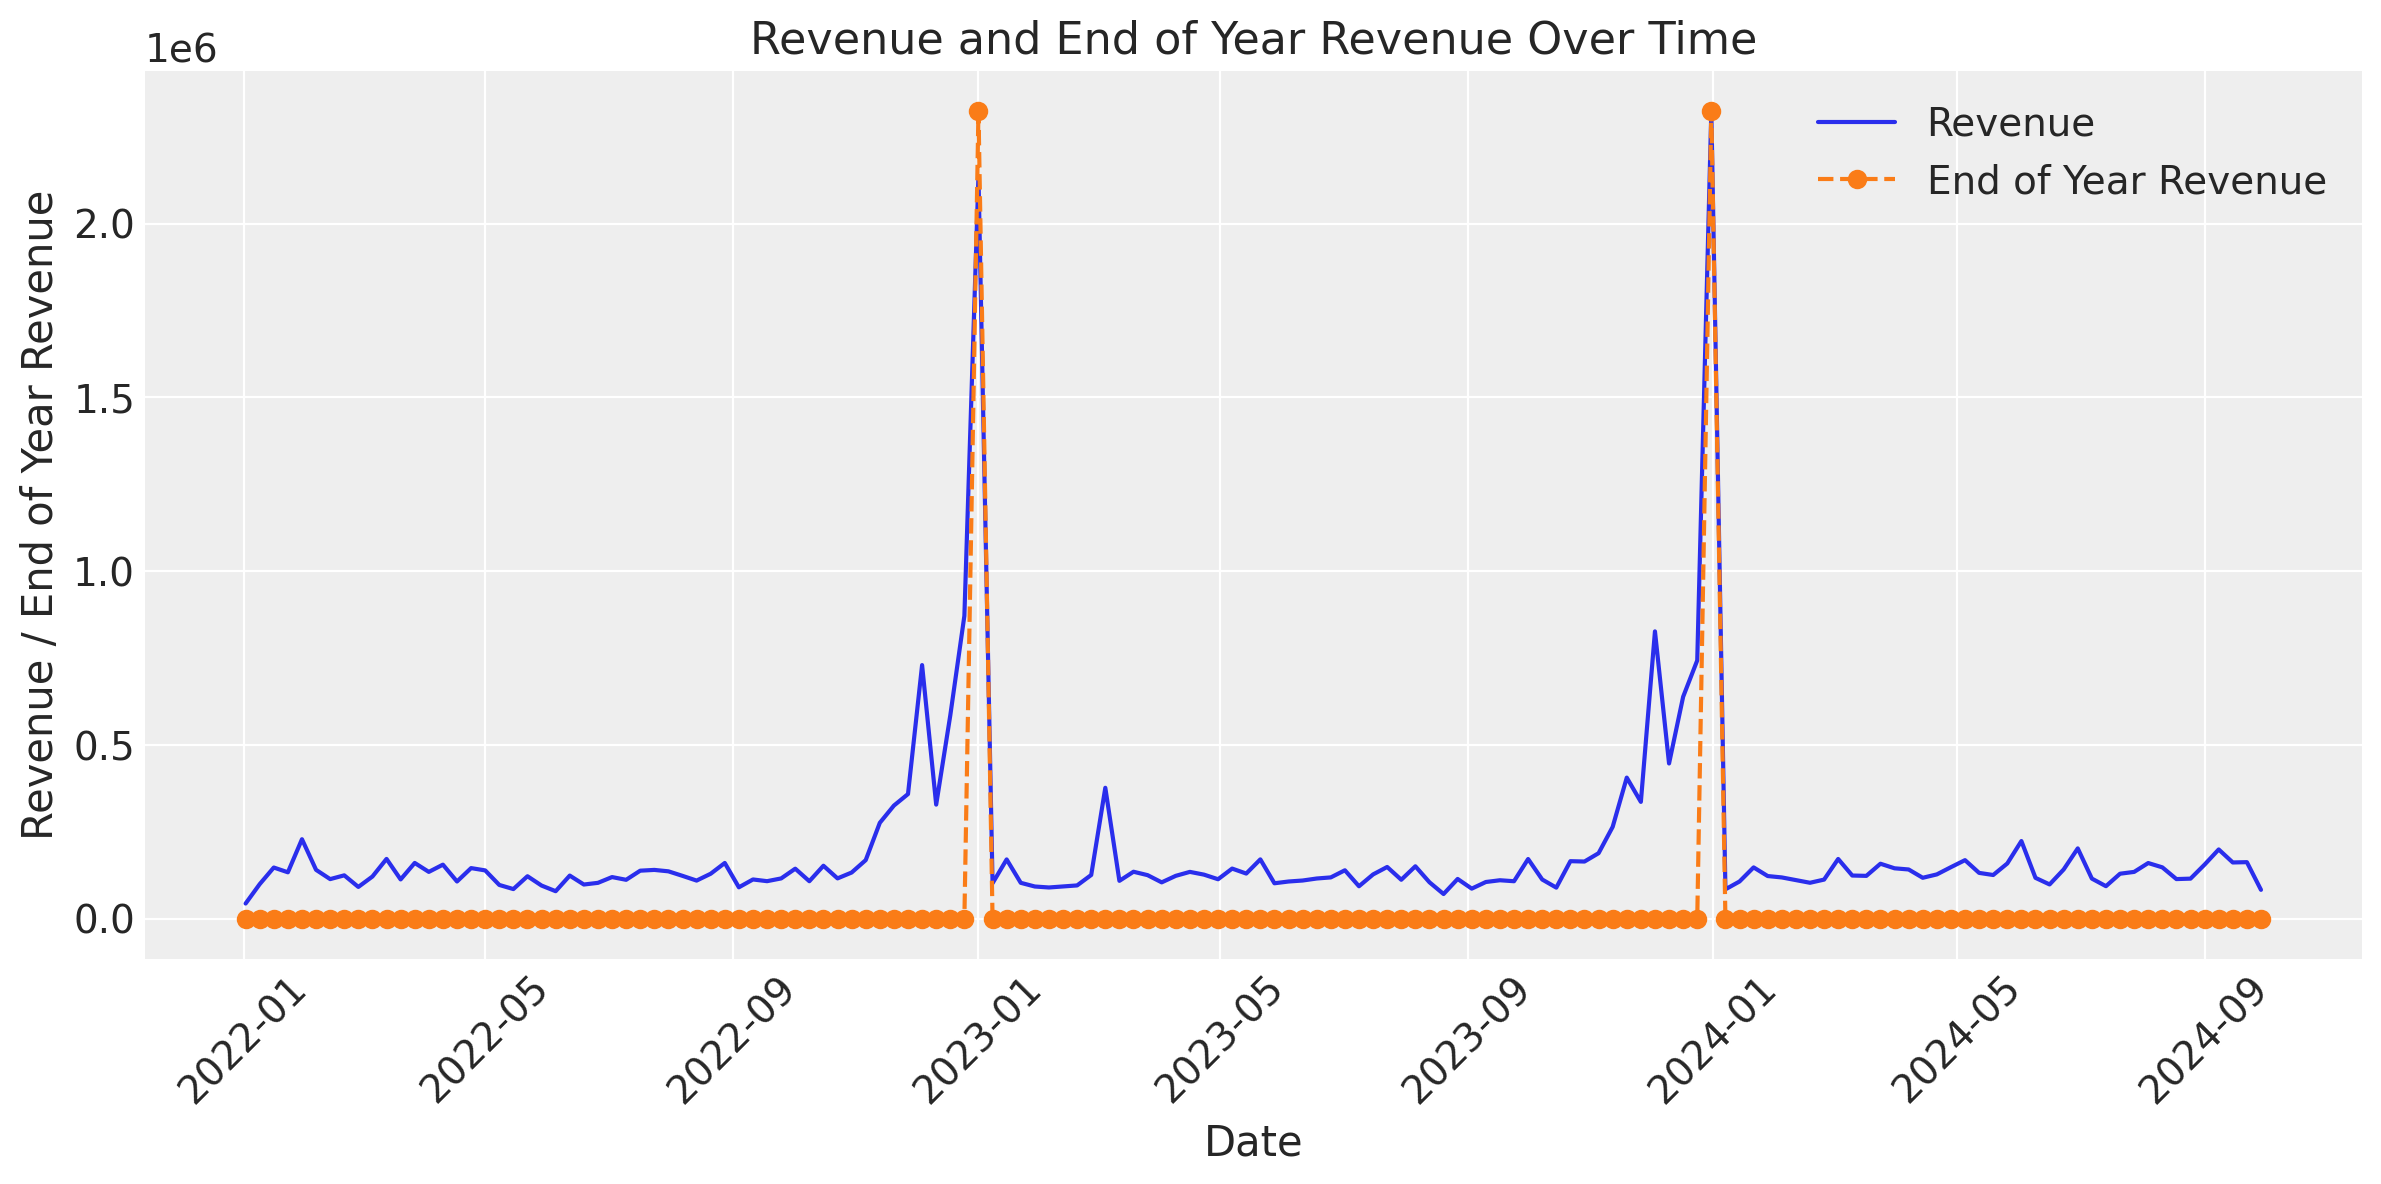

In [ ]:
# prompt: generate chart with Date as x axis and revenue and end of year on y axis

import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame as defined in the previous code

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Revenue'], label='Revenue')
plt.plot(df['Date'], df['end_of_year'] * df['Revenue'].max(), label='End of Year Revenue', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue / End of Year Revenue')
plt.title('Revenue and End of Year Revenue Over Time')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
df_ = df.set_index('Date')
input_df = df_[['Revenue', *[c for c in df_.columns if 'Impressions' in c], 'end_of_year', 'eoy_campaign', 'trend']]
spend_df = df_[['Revenue', *[c for c in df_.columns if 'Spend' in c]]]

In [ ]:
seed: int = sum(map(ord, "mmm"))
rng: np.random.Generator = np.random.default_rng(seed=seed)


#df = spend_df.copy()
df = input_df.copy()
df = df.reset_index()

n = df.shape[0]
print(f"Number of observations: {n}")

Number of observations: 144


In [ ]:
data = df.copy()
X = data.drop("Revenue", axis=1)
y = data["Revenue"]

In [ ]:
data.dtypes

,0
Date,datetime64[ns]
Revenue,float64
Bing_Branded_Impressions,float64
Bing_NonBranded_Impressions,float64
DM_Impressions,float64
Email_Impressions,float64
FB_Impressions,float64
GoogleAds_Branded_Impressions,float64
GoogleAds_NonBranded_Impressions,float64
Programatic_Impressions,float64


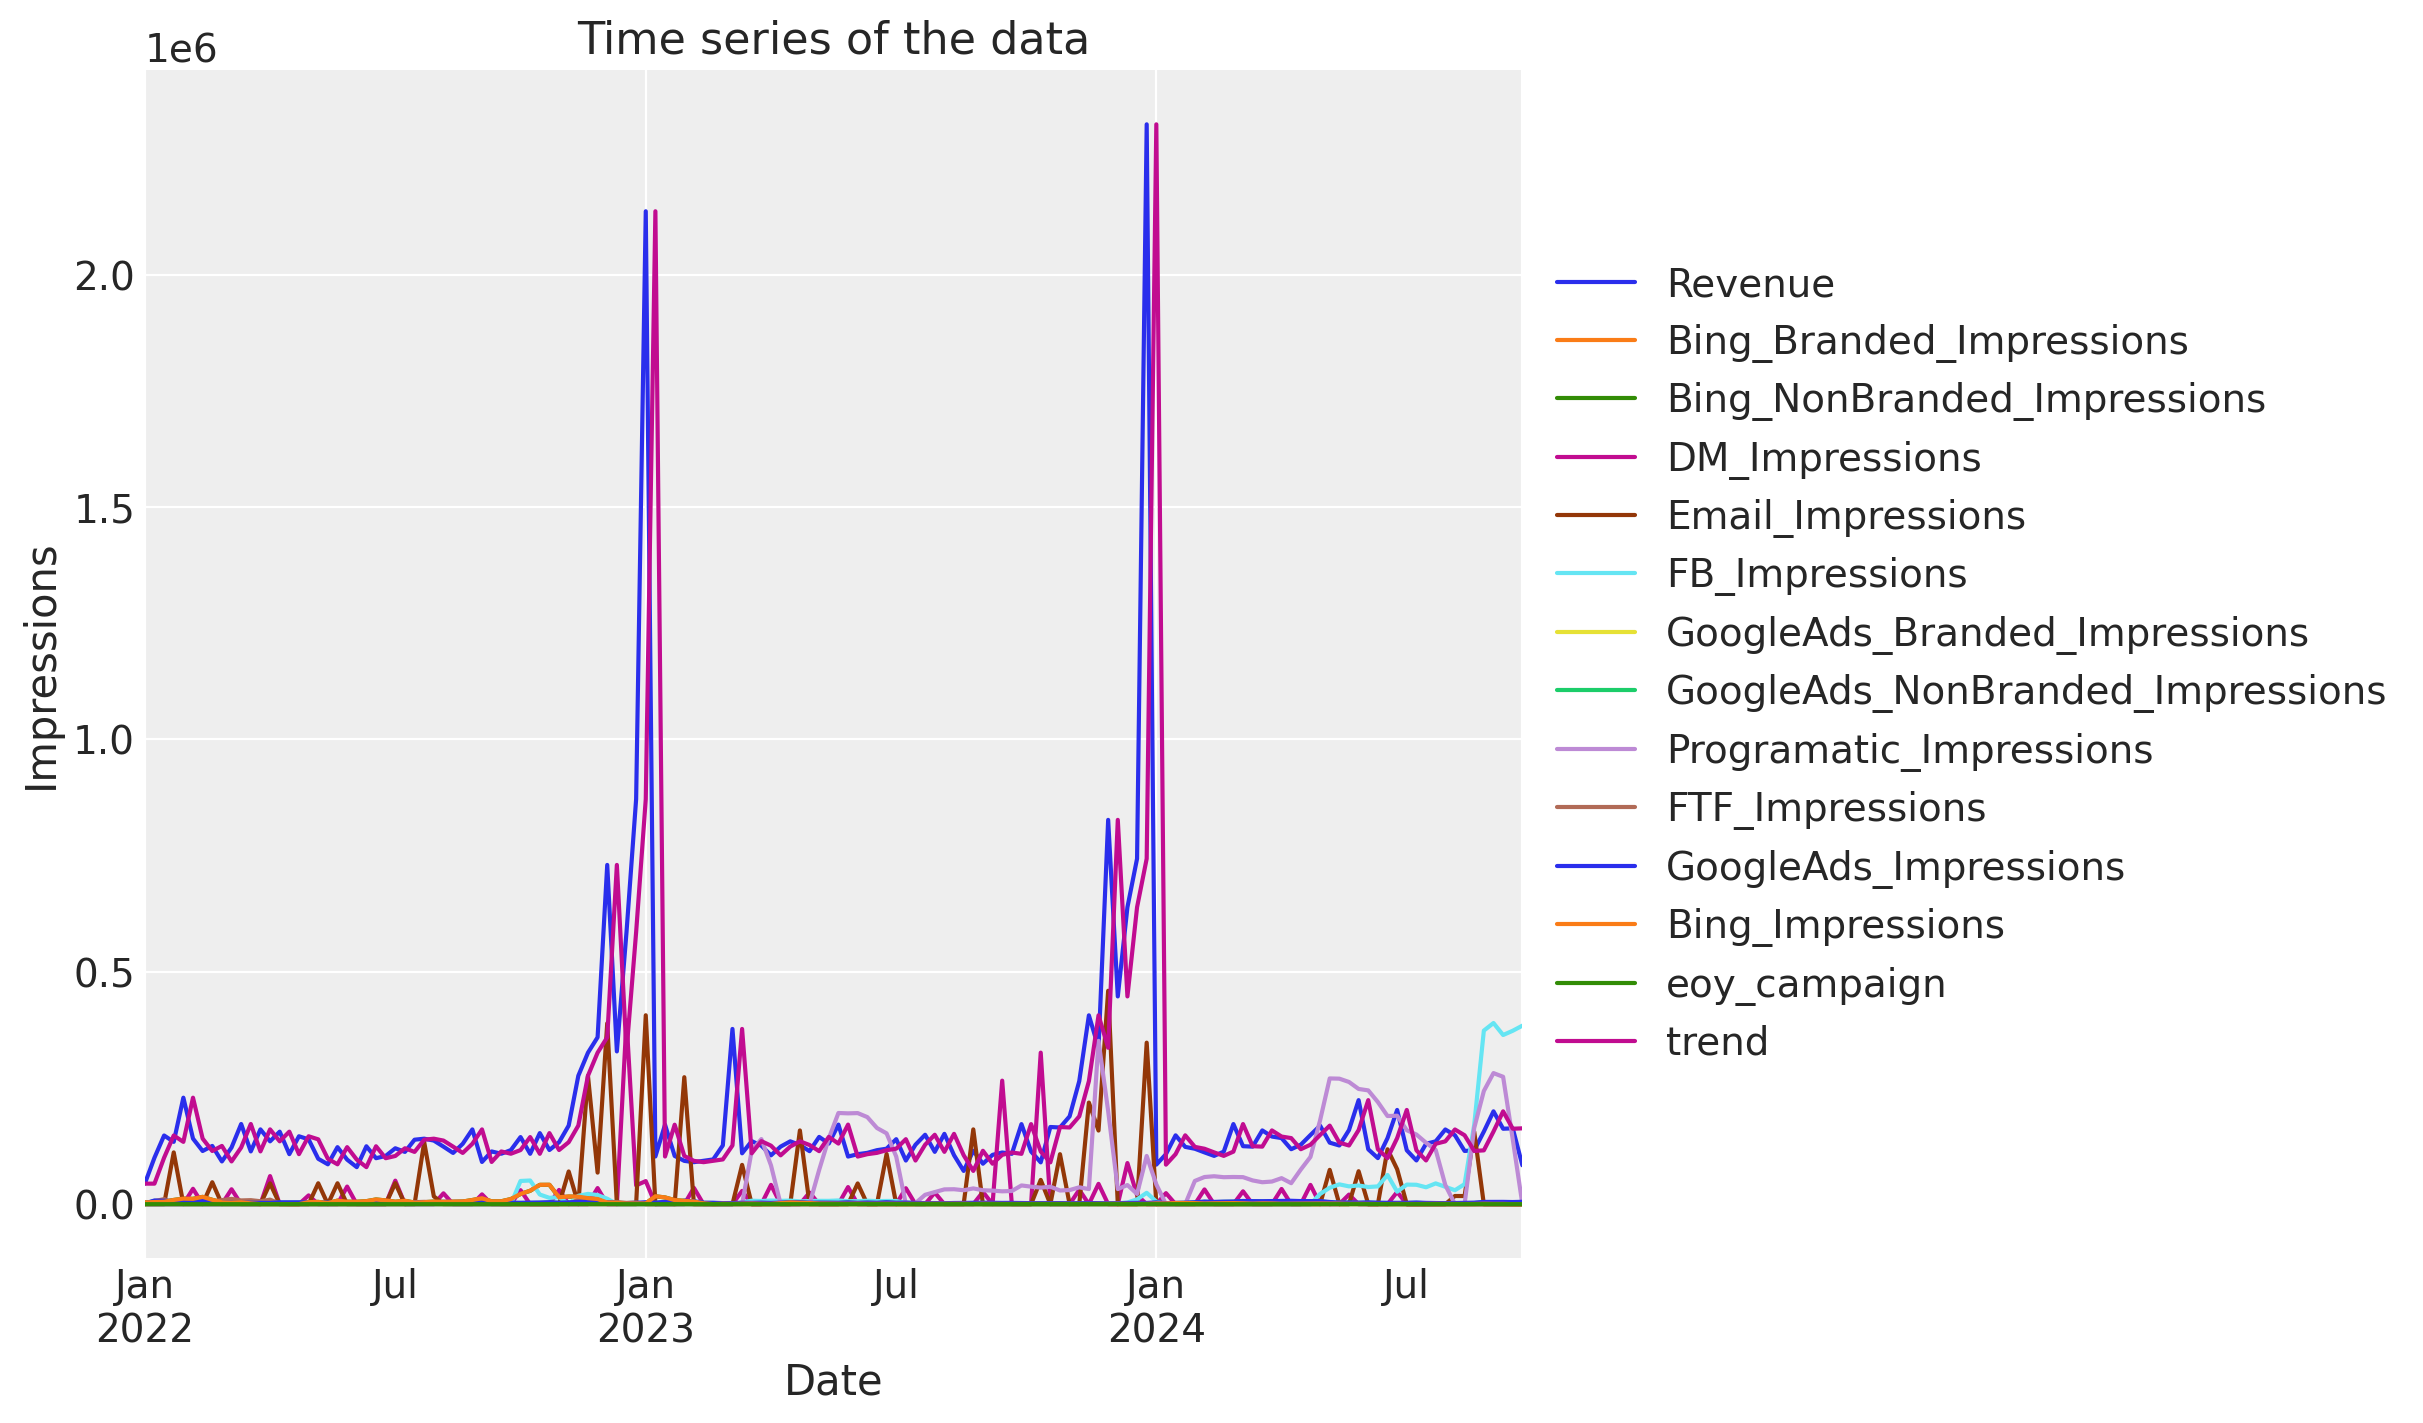

In [ ]:
fig, ax = plt.subplots()
data.set_index("Date").plot(ax=ax)
ax.set_title("Time series of the data")
ax.set_ylabel("Impressions")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5));

In [ ]:
from pymc_marketing.prior import Prior
import pymc_marketing.mmm as mmm

In [ ]:
sampler_config = {"progressbar": True}

In [ ]:
custom_config = {
    "intercept": Prior("HalfNormal", sigma=10),
    "saturation_beta": Prior(
        "Gamma",  sigma=5, dims="channel"
    ),
    "gamma_control": {
        "dist": "HalfNormal",
        "kwargs": { "sigma": 2.5}
    },
     "gamma_fourier": {
        "dist": "Laplace",
        "kwargs": { "mu":0,"b": 2}
    },

    "saturation_lam": Prior("Gamma", alpha=4, beta=4, dims="channel"),
}


media_tvp_config = {
    "media_tvp_config": {
        "m": 50,
        "L": 30,
        "eta_lam": 2,
        "ls_mu": 2,
        "ls_sigma": 5,
        "cov_func": None,
    }
}

custom_config = {**custom_config, **media_tvp_config}

ch = ['Bing_Impressions', 'DM_Impressions', 'Email_Impressions',
       'FB_Impressions', 'GoogleAds_Impressions', 'Programatic_Impressions',
       'FTF_Impressions']

mmm = MMM(
    model_config=custom_config,
    sampler_config=sampler_config,
    date_column="Date",
    adstock=GeometricAdstock(l_max=12),
    saturation=MichaelisMentenSaturation(),
    channel_columns=ch,
    control_columns=[
                 'eoy_campaign', 'end_of_year','trend'
    ],
    yearly_seasonality = 2,
    time_varying_media=True,
    time_varying_intercept=True
)

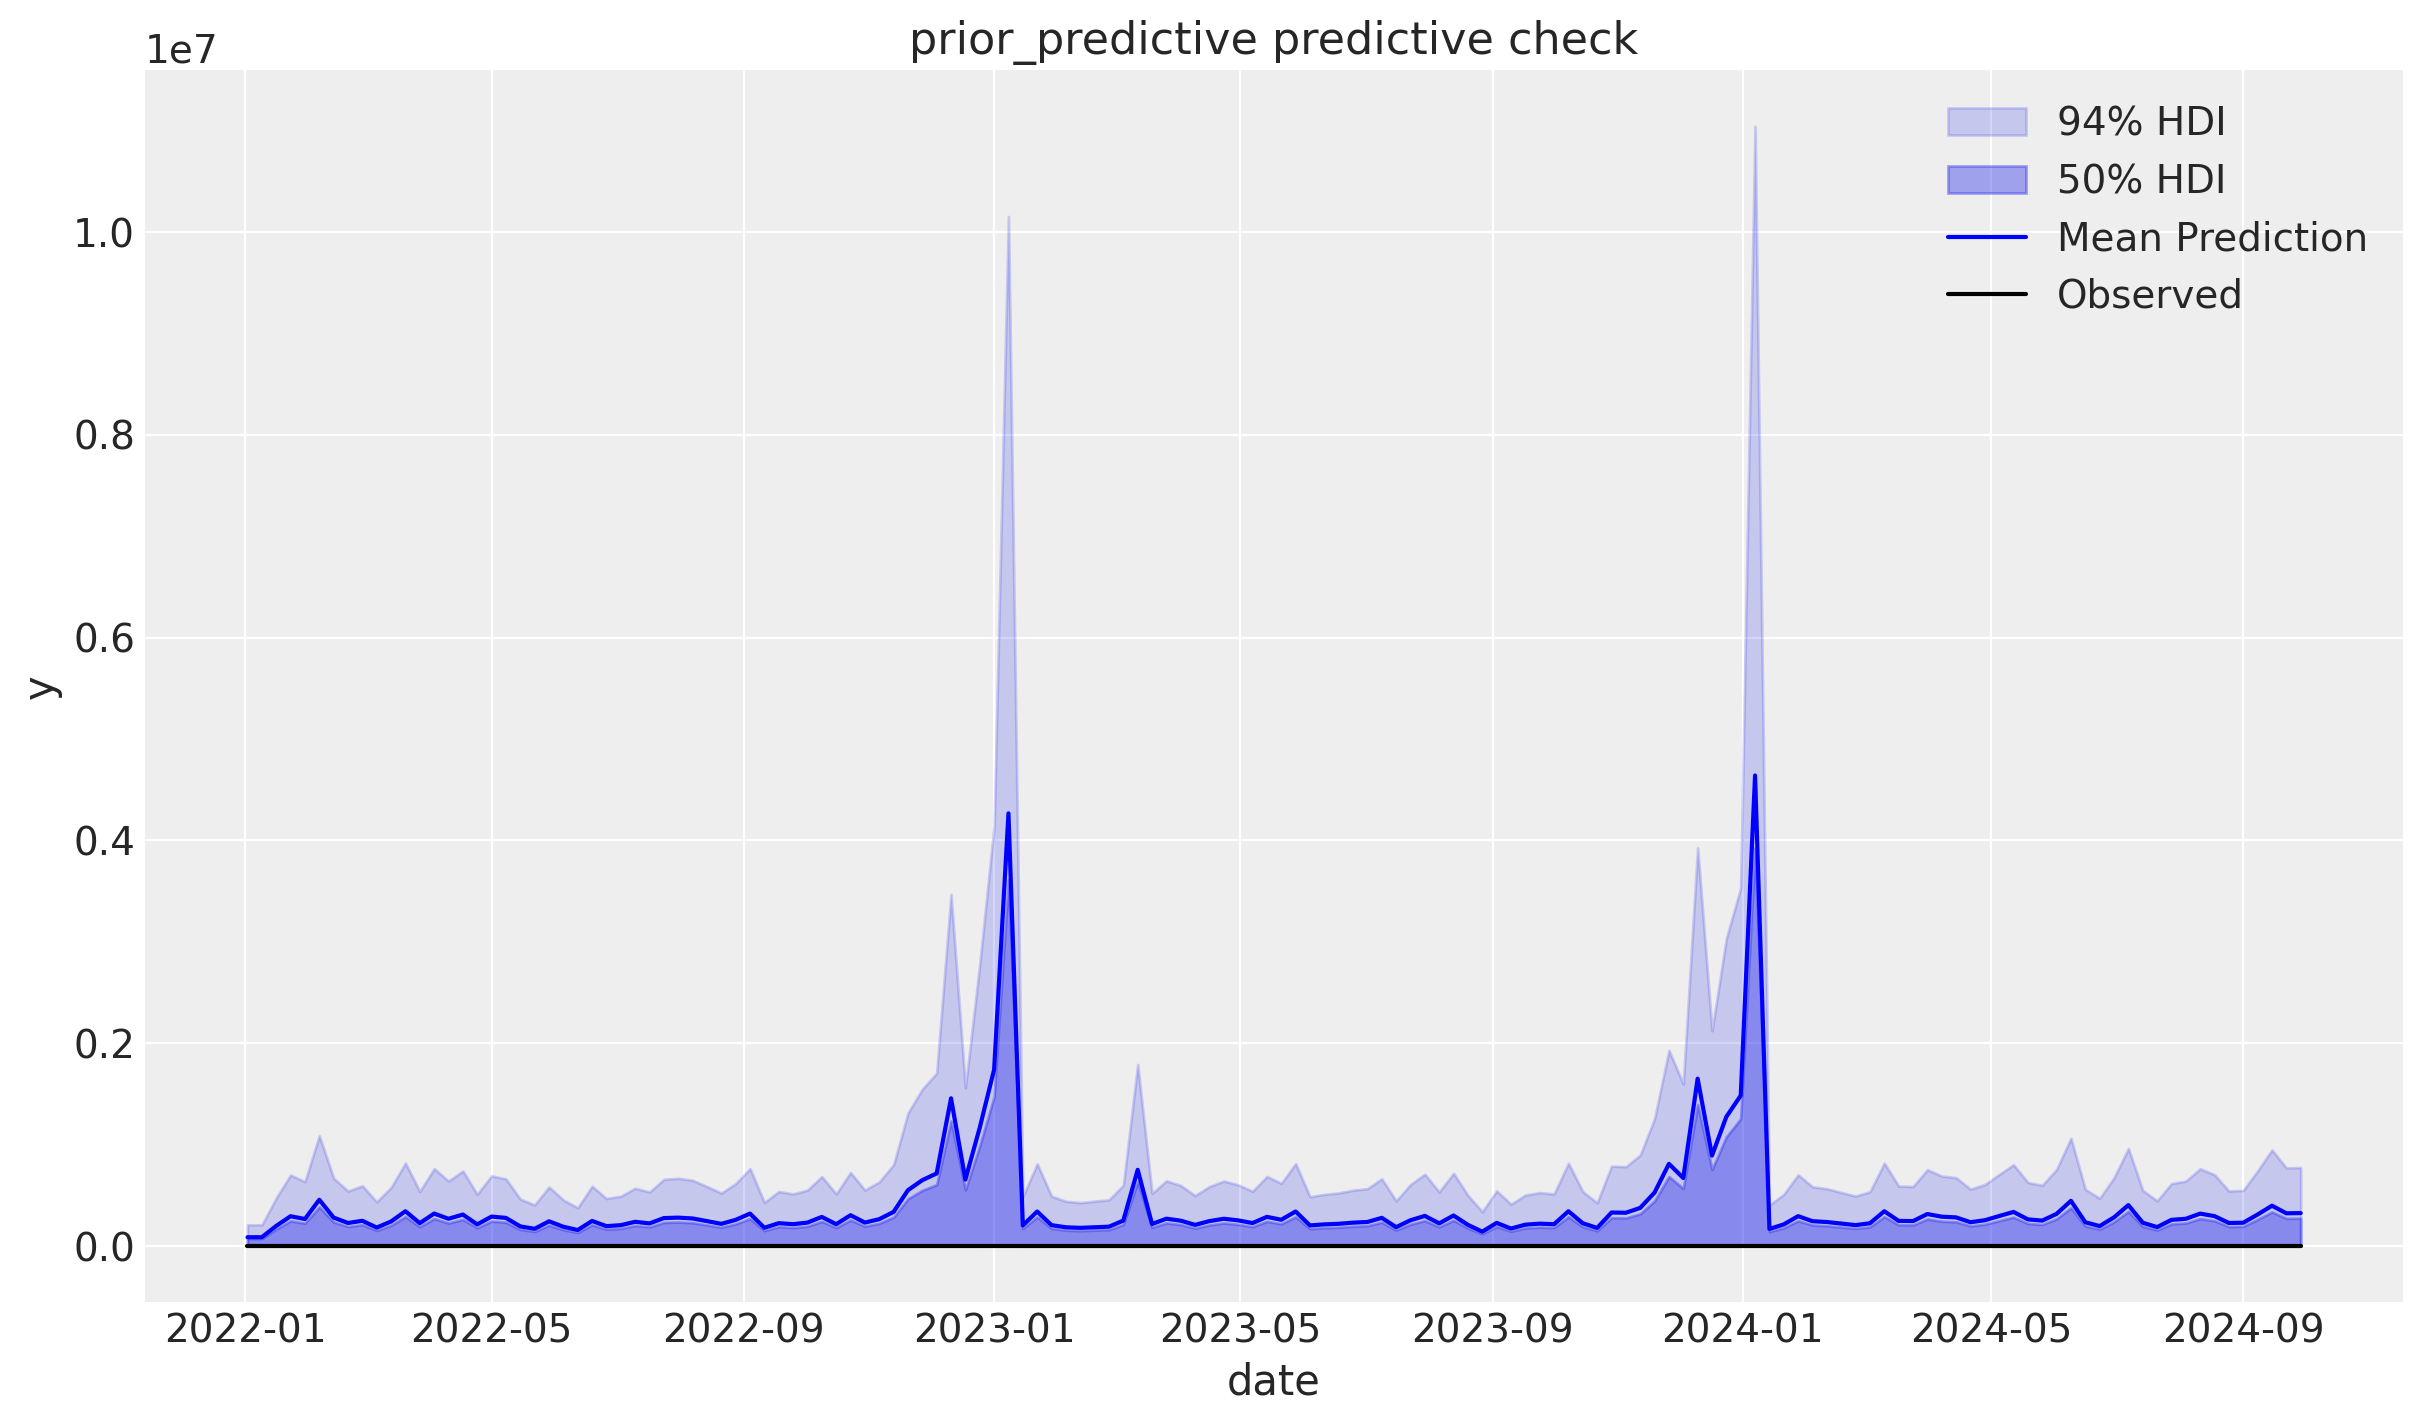

In [ ]:
# Generate prior predictive samples
mmm.sample_prior_predictive(X, y, samples=6_000)

mmm.plot_prior_predictive();

In [ ]:
mmm.fit(X=X, y=y, nuts_sampler="numpyro",target_accept=0.95, chains=4, draws=6_000, random_seed=rng)

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data
	> fit_data

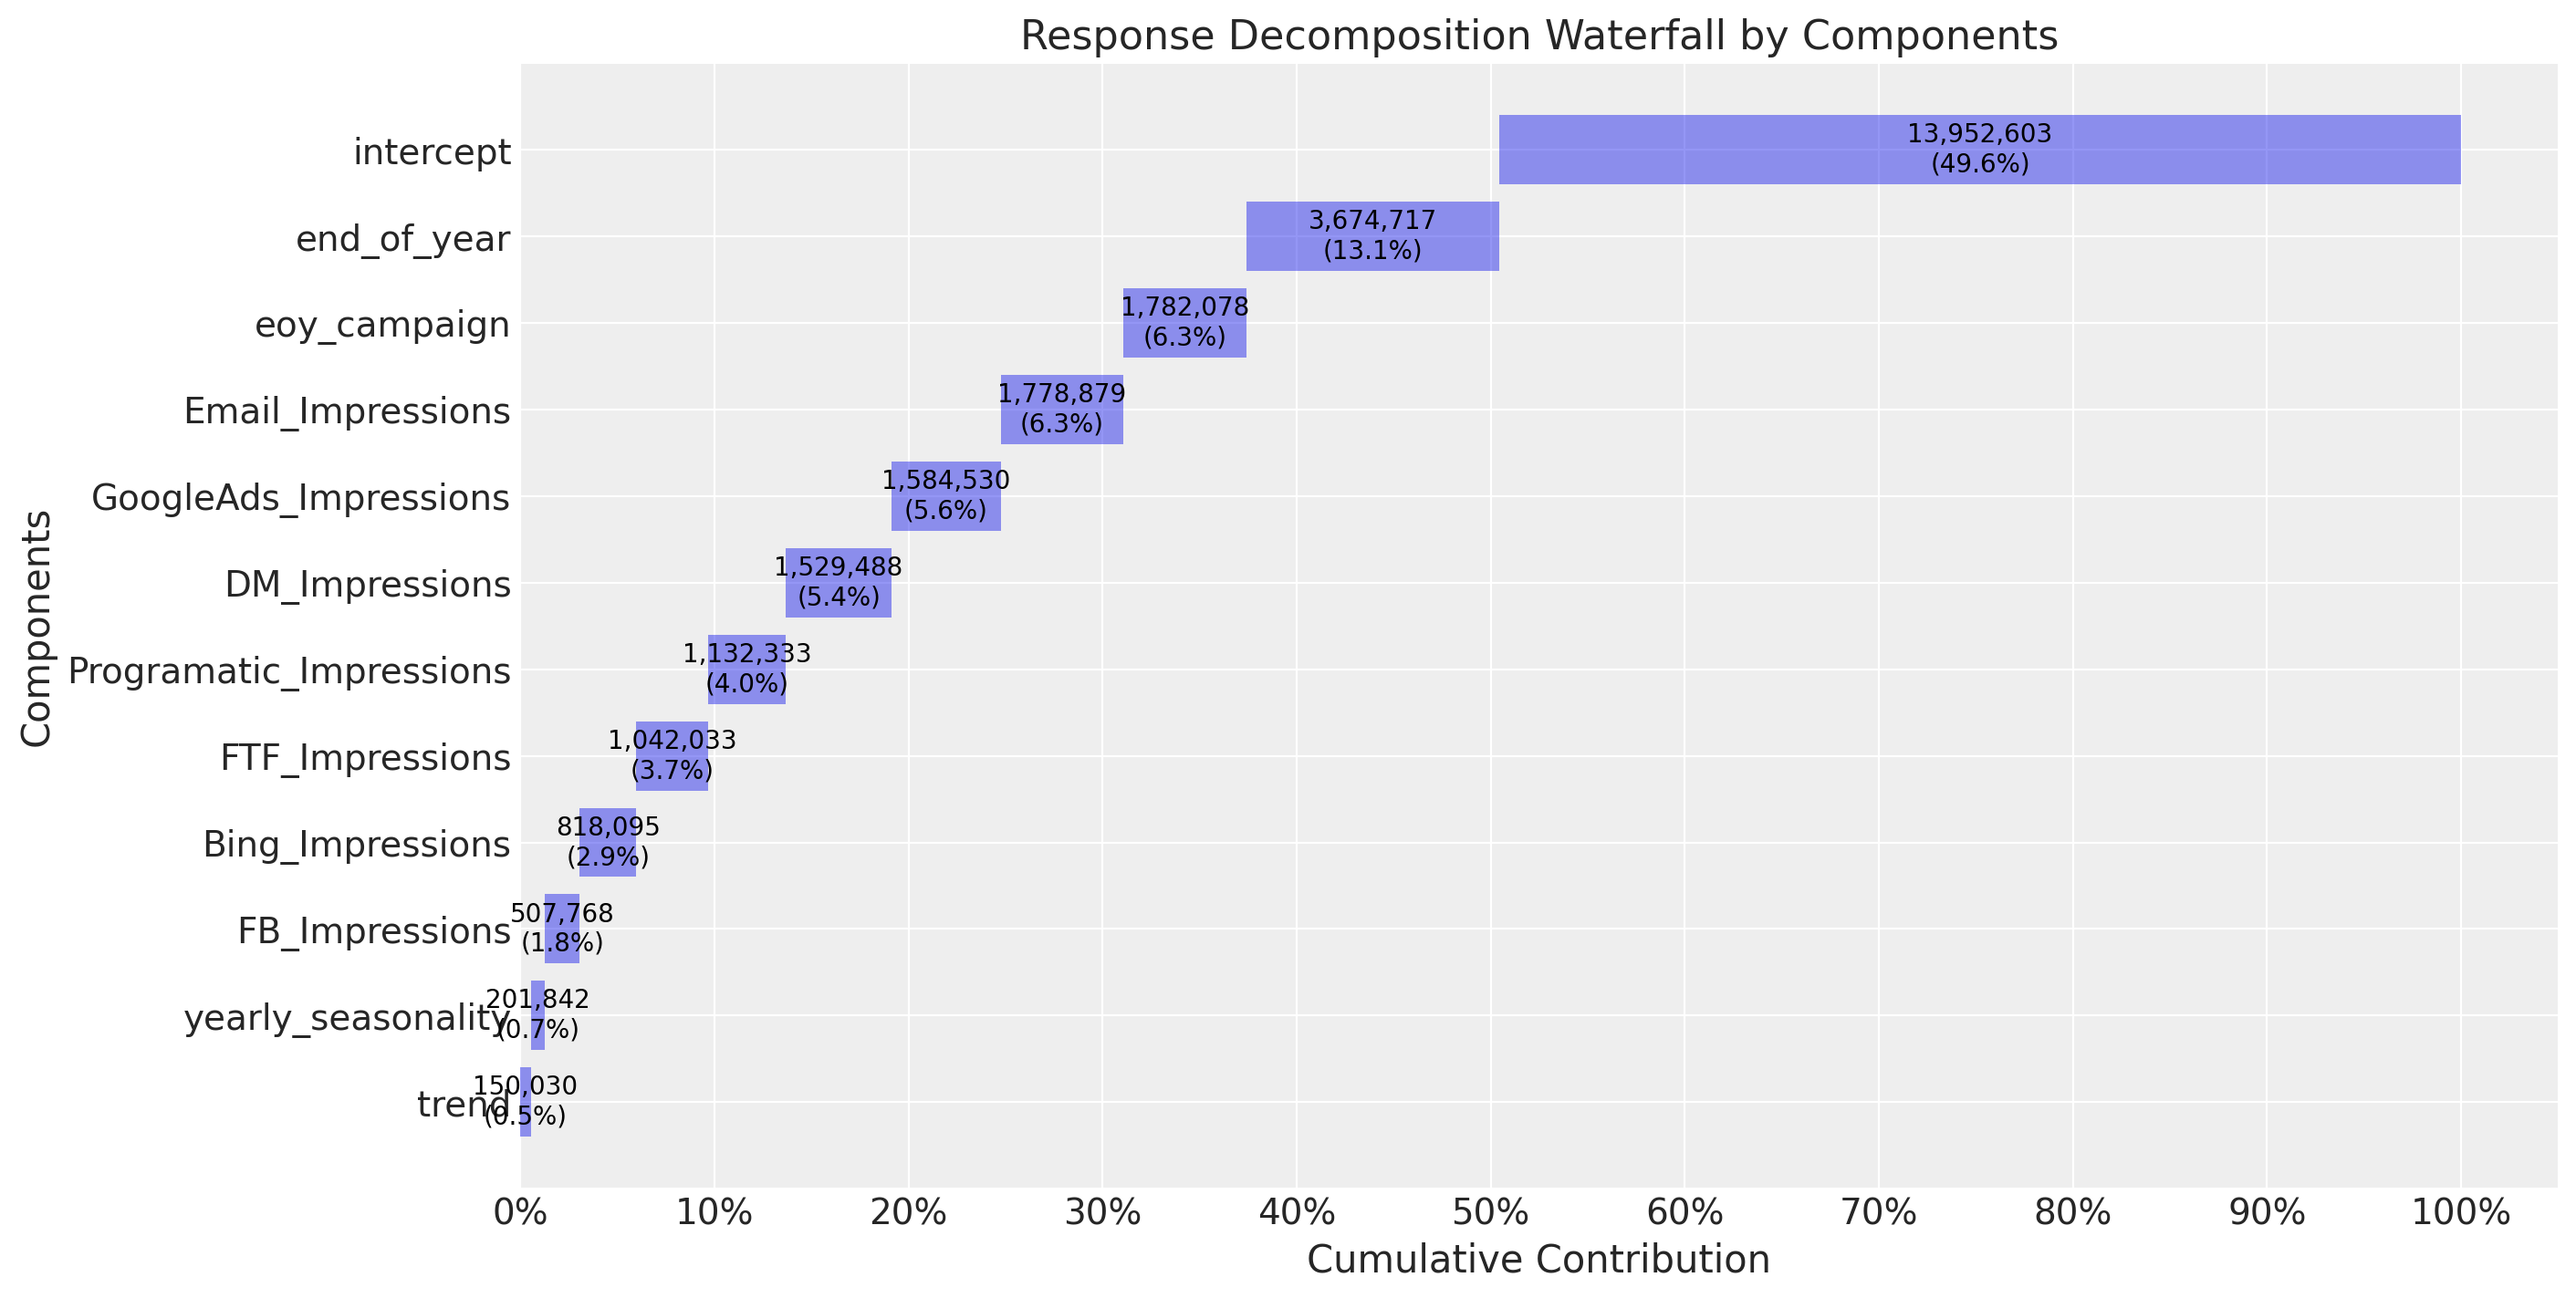

In [ ]:
mmm.plot_waterfall_components_decomposition();

In [ ]:
X['end_of_year'] = X['end_of_year'].astype(int)

In [ ]:
from sklearn.metrics import r2_score

def get_mape(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    mape = np.mean(np.abs((y - y_pred) / y)) * 100
    print(f"MAPE: {mape}")

def get_r2(mmm_):
    y_pred = mmm_.predict(X)  # Use the original X DataFrame with datetime 'Date'
    r2 = r2_score(y, y_pred)
    return r2


In [ ]:
print(get_mape(mmm))
print(get_r2(mmm))

Output()

MAPE: 10.078865173293881
None


Output()

0.9965721703459123


In [ ]:
def get_posterior_check(mmm_):
  mmm_.sample_posterior_predictive(X, extend_idata=True, combined=True)
  mmm_.plot_posterior_predictive(original_scale=True);

Output()

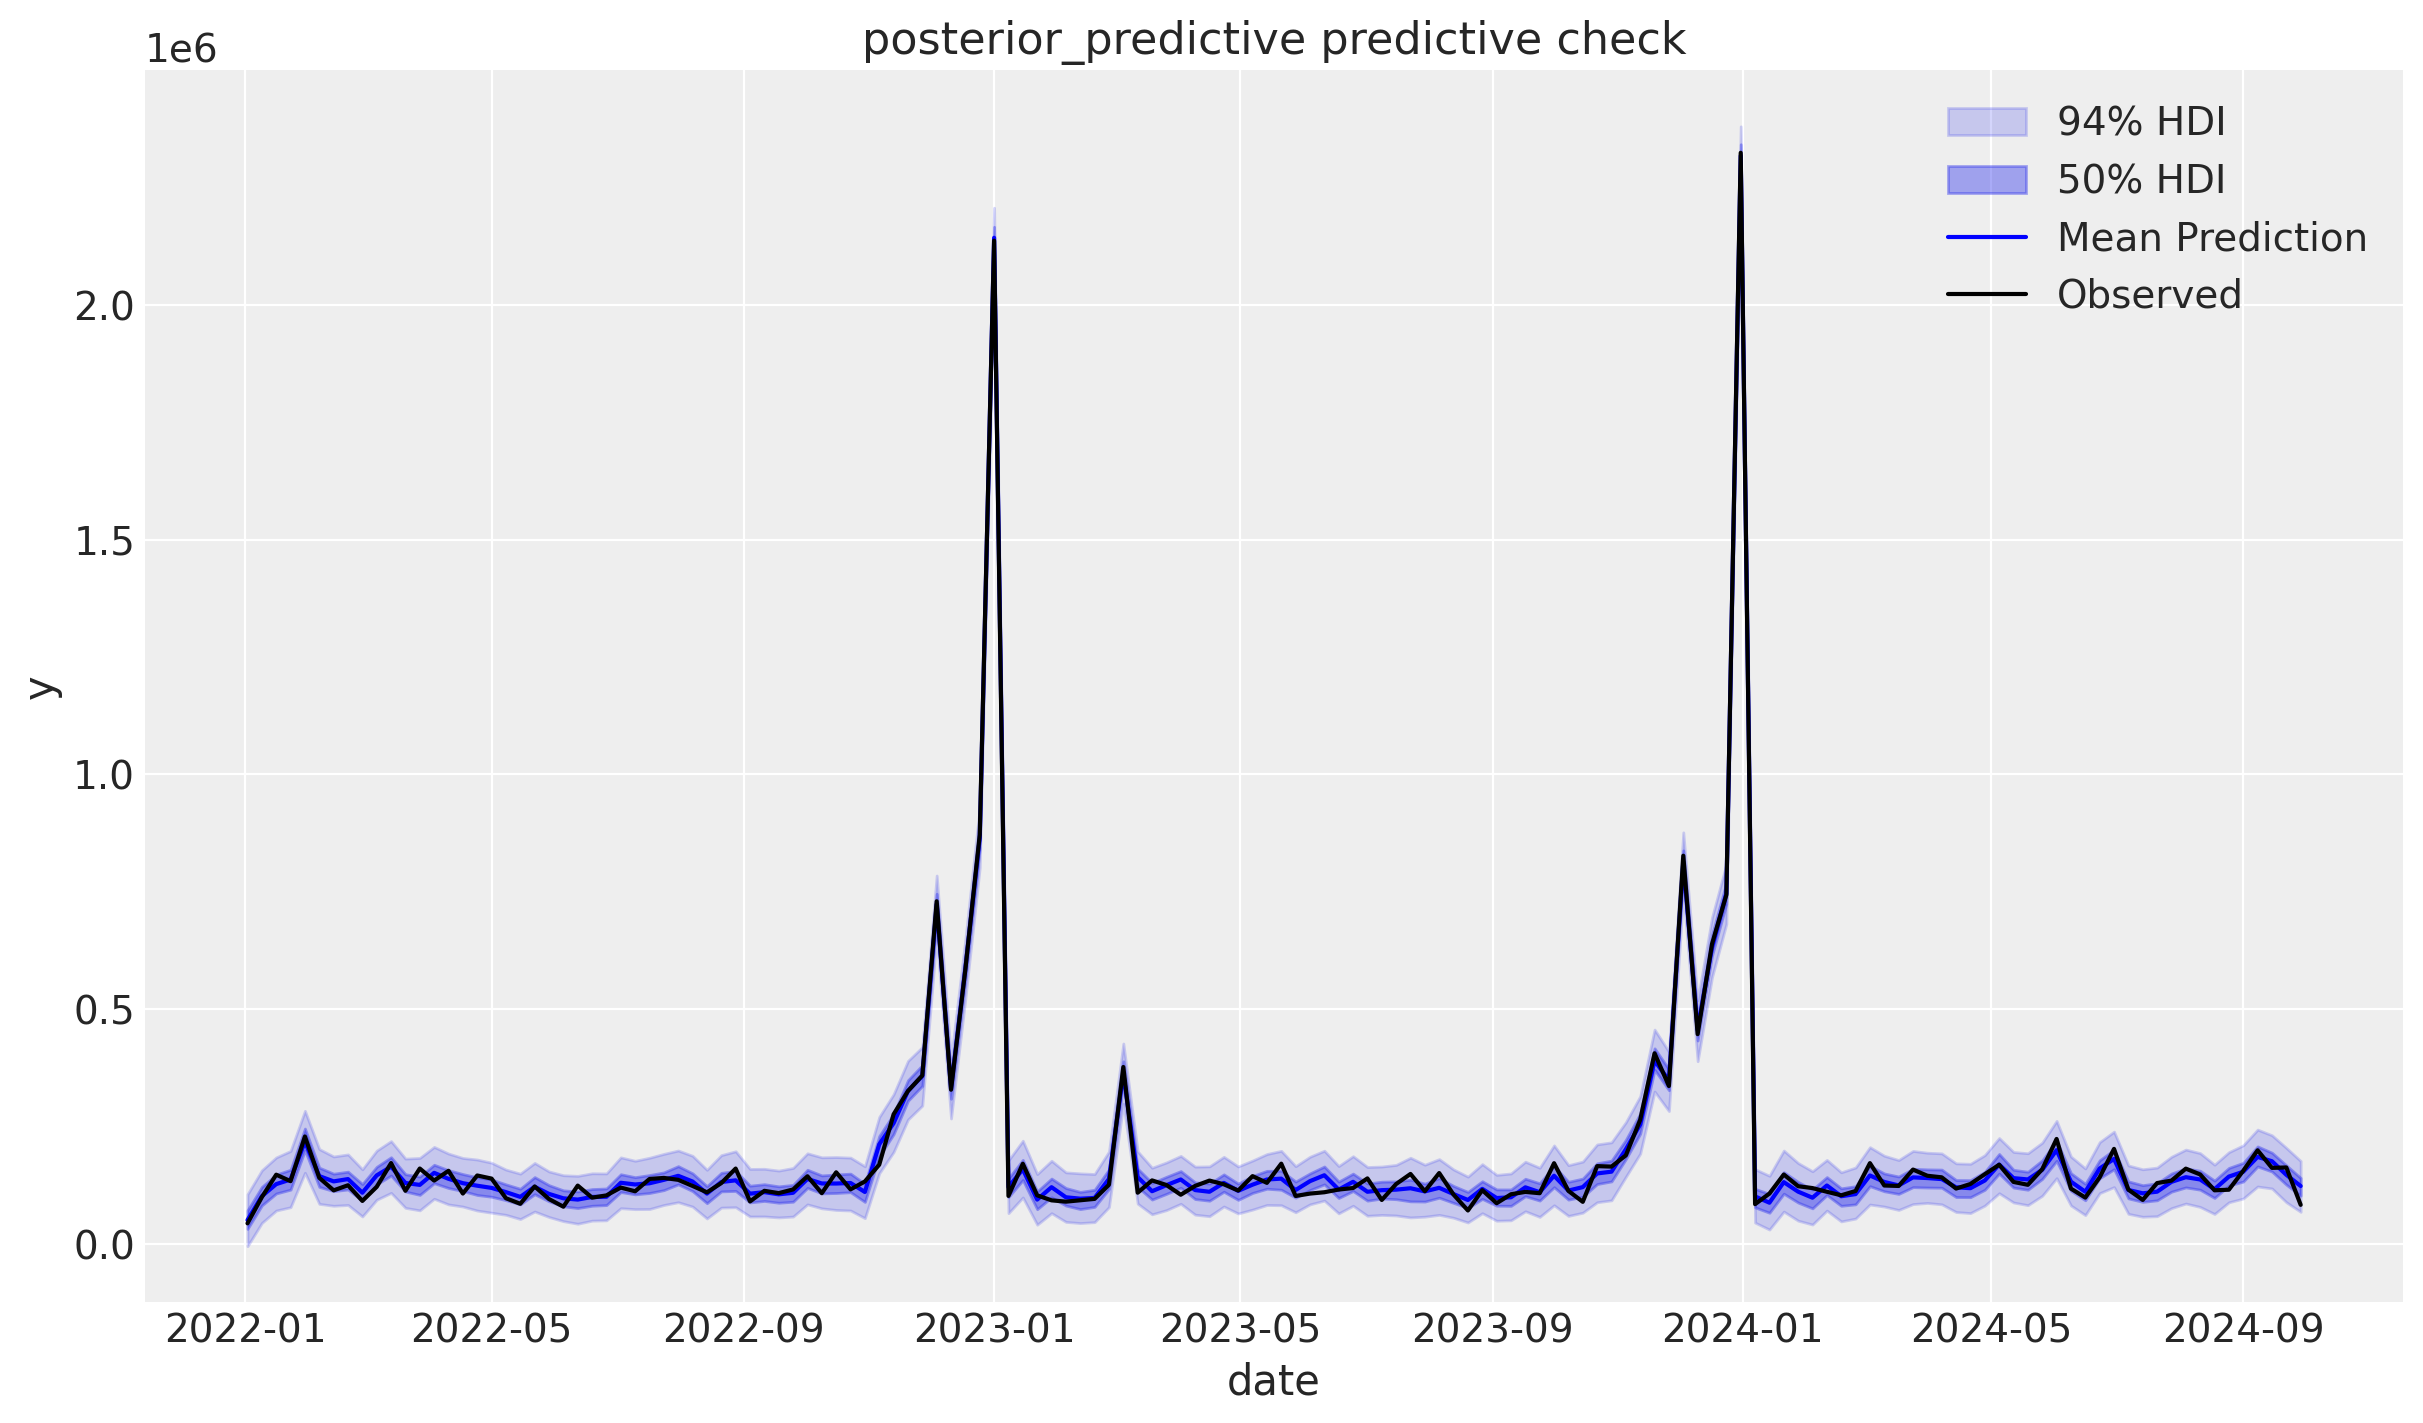

In [ ]:
get_posterior_check(mmm)

In [ ]:
df_res = df[['Date']]
df_res['y'] = y
df_res['y_pred'] = mmm.predict(X)

<ipython-input-33-5a12f9594146>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['y'] = y


Output()

<ipython-input-33-5a12f9594146>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res['y_pred'] = mmm.predict(X)


In [ ]:
df_res

,Date,y,y_pred
0,2022-01-02,44191.70,51017.769553
1,2022-01-09,99989.50,101870.707998
2,2022-01-16,147772.39,127559.245308
3,2022-01-23,134056.43,137347.546517
4,2022-01-30,229189.84,217613.083605
...,...,...,...
139,2024-09-01,156221.84,154591.726002
140,2024-09-08,199752.84,185721.677756
141,2024-09-15,162318.56,176299.012423
142,2024-09-22,163221.03,147271.169290


<ipython-input-35-c0e12ef88a93>:12: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


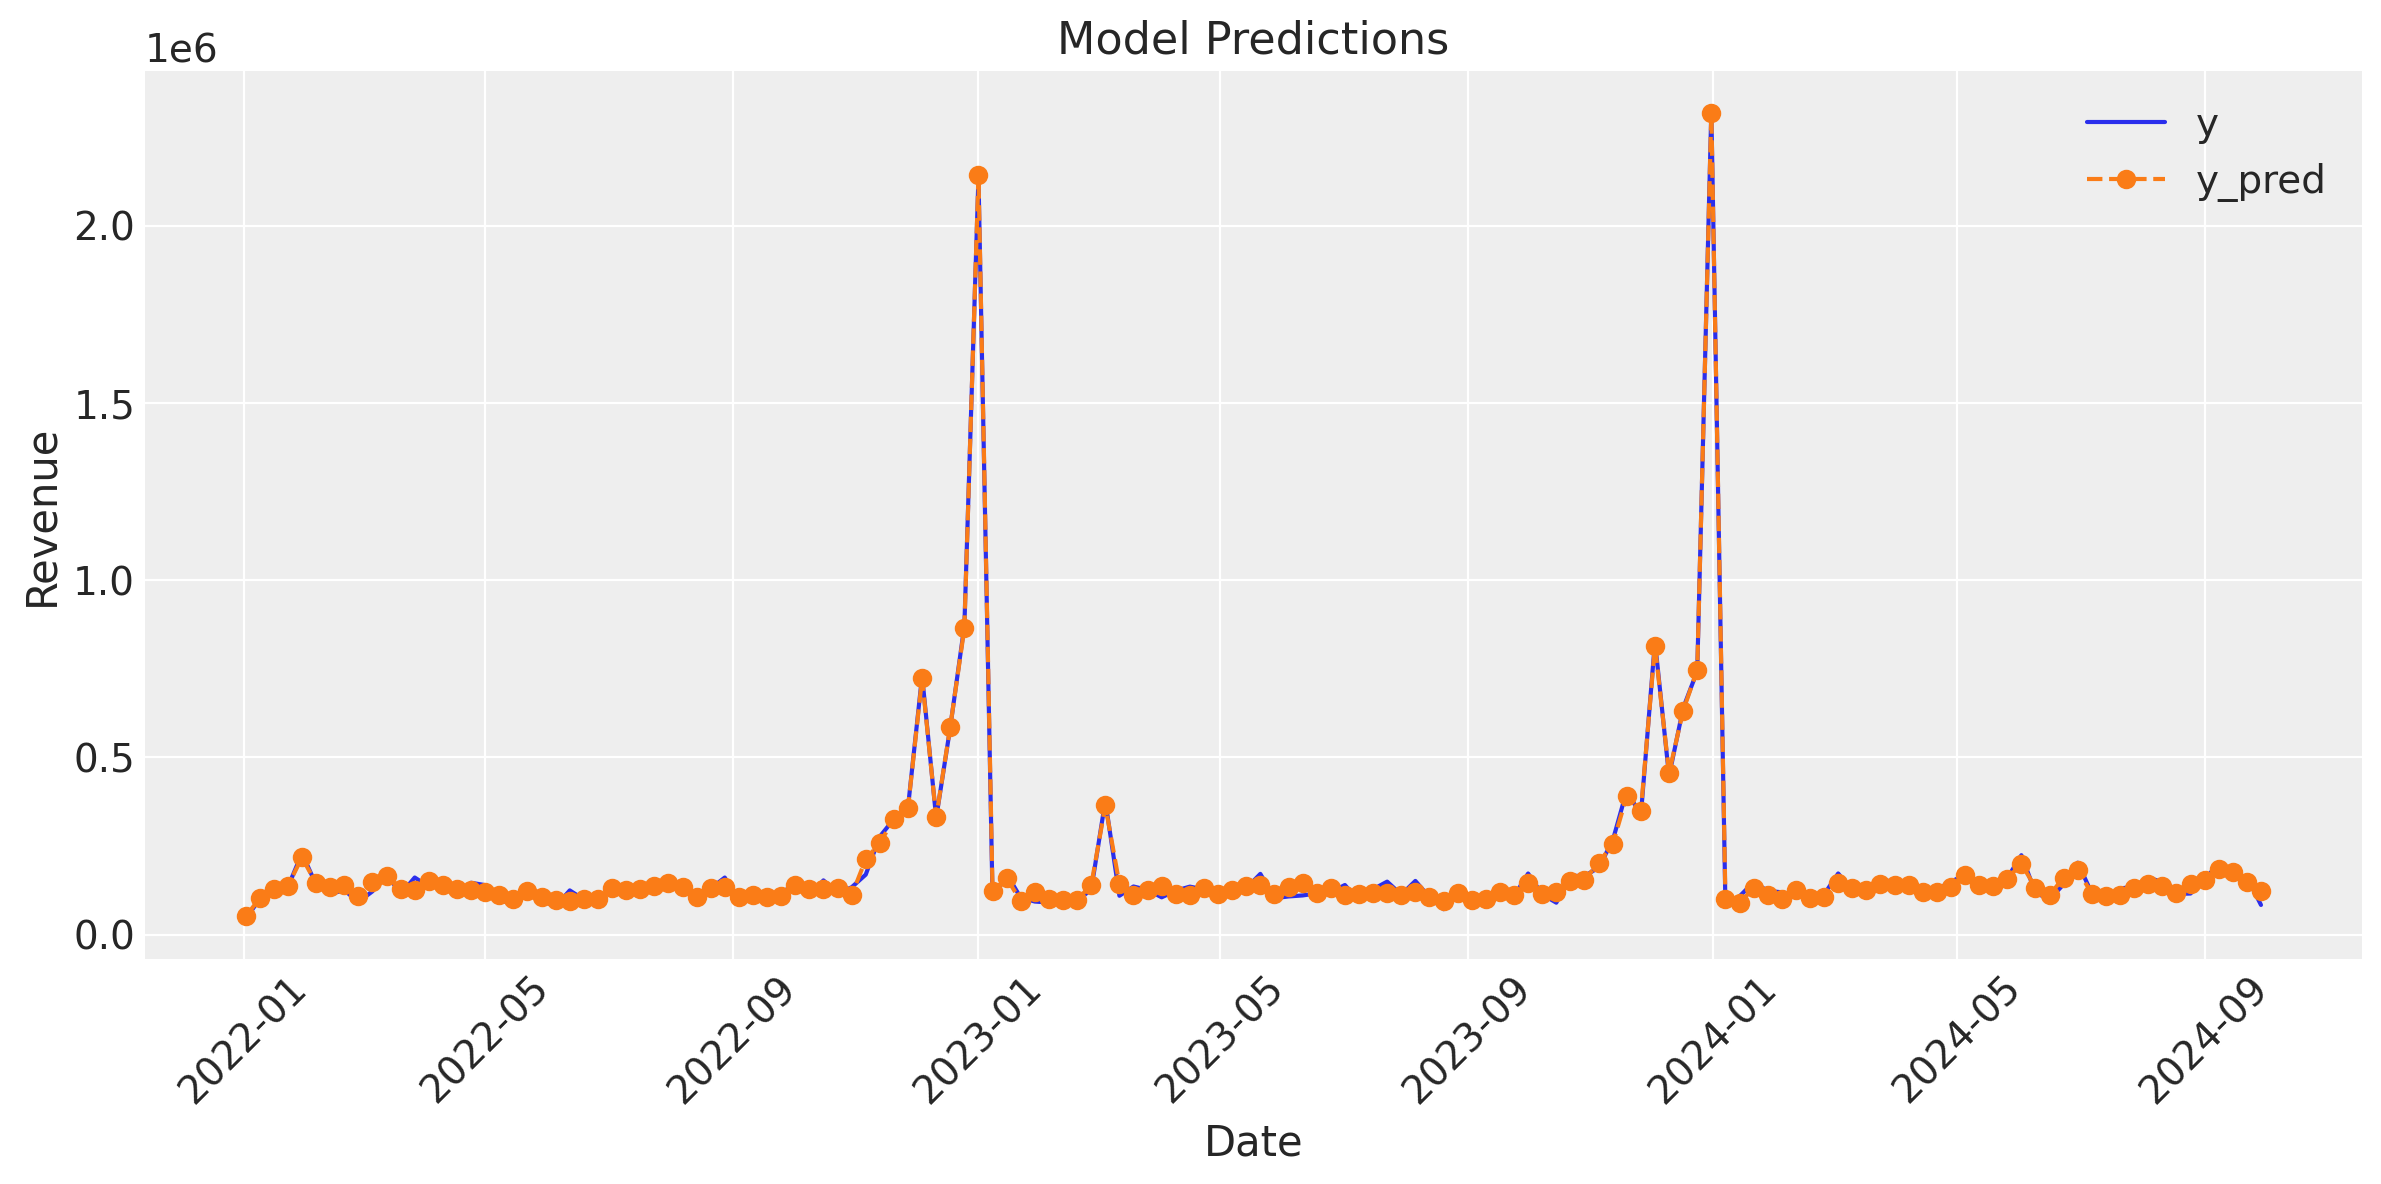

In [ ]:


import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df_res['Date'], df_res['y'], label='y')
plt.plot(df['Date'], df_res['y_pred'], label='y_pred', linestyle='--', marker='o') # Plot EOY Revenue
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Model Predictions')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
